In [1]:
from keras.datasets import cifar10
from keras import optimizers
import numpy as np
from sklearn import preprocessing


(x_train, y_train), (x_test, y_test) = cifar10.load_data()
interested = [0, 1, 8, 9]

scrap = []
for idx, im in enumerate(x_train):
    if (y_train[idx][0] not in interested):
        scrap.append(idx)
        
x_train = np.delete(x_train, scrap, axis=0)
y_train = np.delete(y_train, scrap, axis=0)

enc = preprocessing.OneHotEncoder()
enc.fit(y_train)
y_train = enc.transform(y_train).toarray()

scrap = []
for idx, im in enumerate(x_test):
    if (y_test[idx][0] not in interested):
        scrap.append(idx)
x_test = np.delete(x_test, scrap, axis=0)
y_test = np.delete(y_test, scrap, axis=0)
y_test = enc.transform(y_test).toarray()

x_train = (x_train.astype('float32')) / 255.0
x_test = (x_test.astype('float32')) / 255.0

print x_train.shape
print x_test.shape

Using TensorFlow backend.


(20000, 32, 32, 3)
(4000, 32, 32, 3)


In [3]:
from keras.models import load_model

feature_extractor = load_model('extractor.h5')
feature_encoder = load_model('ae-encoder.h5')
print "Models loaded!"

Models loaded!


In [4]:
features = feature_extractor.predict(x_train)
print features.shape

(20000, 2048)


In [5]:
vectors = feature_encoder.predict(features)
print vectors.shape

(20000, 128)


In [6]:
import numpy as np
from annoy import AnnoyIndex

index = AnnoyIndex(vectors.shape[1])
for i in range(vectors.shape[0]):
    index.add_item(i, vectors[i,:].tolist())

In [7]:
index.build(20)
index.save("index.ann")

True

In [15]:
labels = ['airplane', 'automobile', 'ship', 'truck']
lookup = np.argmax(y_train[:, :], axis=1)

Querying with this random image


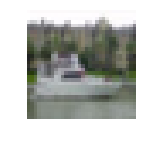

ship


In [20]:
import random
choice_idx = random.randrange(20000)
results = index.get_nns_by_item(choice_idx, 100)

print "Querying with this random image"

import matplotlib.pyplot as plt
plt.figure(figsize=(2,2))
plt.imshow(x_train[choice_idx])
plt.axis('off')
plt.show()
print labels[lookup[choice_idx]]

Search results:


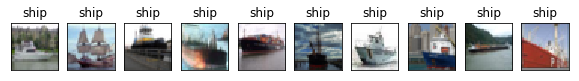

In [21]:
import matplotlib.pyplot as plt


print "Search results:"

plt.figure(figsize=(10,4))
for i in range(10):
    ax = plt.subplot(1, 10, i+1)
    plt.imshow(x_train[results[i]])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title(str(labels[lookup[results[i]]]))

plt.show()

In [22]:
from sklearn.metrics import f1_score
t = np.ones(100).astype(float)
p = np.array([lookup[x] == lookup[choice_idx] for x in results]).astype(float)

print "F1 Score for this search:", f1_score(t, p)

F1 Score for this search: 1.0
